In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import os
import sys
import glob
from scipy.sparse.linalg import eigs
from sklearn.decomposition import PCA
from tqdm import tqdm
from scipy.sparse.linalg import eigsh

In [2]:
# 2024: Python implementation by NE

# path for mouse subjects
OD = '/home/fs0/ssf619/scratch/mouse_migp/mouse_subjects'
path = '/home/fs0/ssf619/scratch/mouse_migp/mouse_subjects/*_FIXed_QBI.nii.gz'
fnames_list = glob.glob(path)

# # path for human subjects
# OD = '/home/fs0/ssf619/scratch/human_subjects_5mmsmoothed'
# path = '/home/fs0/ssf619/scratch/human_subjects_5mmsmoothed/*_5mm.nii.gz'
# fnames_list= glob.glob(path)

print(fnames_list[0]) # check files
print(f'no. of subjects = {len(fnames_list)}')


/home/fs0/ssf619/scratch/mouse_migp/mouse_subjects/001_FIXed_QBI.nii.gz
no. of subjects = 50


(51, 38, 98)


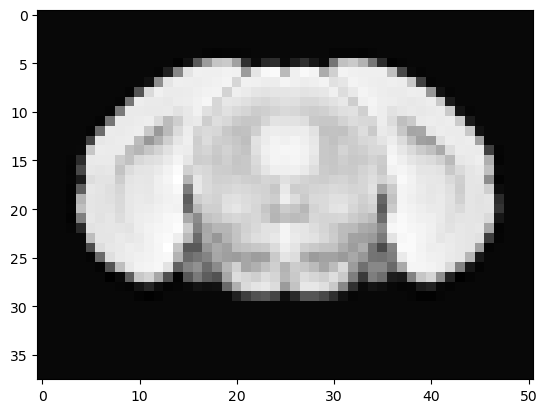

In [3]:
# get ref image with 1 volume
ref_img_fname = f'{OD}/func_ref.nii.gz'
os.system(f'fslmaths {fnames_list[0]} -Tmean {ref_img_fname}')
ref_img = nib.load(ref_img_fname)
print(ref_img.shape)

# Plot a slice of that volume 
data = ref_img.get_fdata();
plt.imshow(data[:,:,45].T,cmap='Greys_r')

In [4]:
# get brain_mask by loading data from three subjects, averaging, and binarizing
n_subs = 3
dims = ref_img.header.get_data_shape()
avgs = np.zeros((dims[0], dims[1], dims[2], n_subs))
print(avgs.shape)
for i_sub, fname in enumerate(fnames_list[0:n_subs]):
    print(f'load {fname}')
    y = nib.load(fname).get_fdata()
    avgs[:,:,:,i_sub] = np.std(y, axis=3)
avg = np.mean(avgs, axis=3)

# save binarized mask
new_hdr = ref_img.header
niftiobj = nib.Nifti1Image((avg>0).astype(int), new_hdr.get_best_affine(), new_hdr)
nib.save(niftiobj, f'{OD}/func_brain_mask.nii.gz')

(51, 38, 98, 3)
load /home/fs0/ssf619/scratch/mouse_migp/mouse_subjects/001_FIXed_QBI.nii.gz
load /home/fs0/ssf619/scratch/mouse_migp/mouse_subjects/014_FIXed_QBI.nii.gz
load /home/fs0/ssf619/scratch/mouse_migp/mouse_subjects/049_FIXed_QBI.nii.gz


In [5]:
# define number of components to keep
p_comps = 0.1
n_components_pca = nib.load(fnames_list[0]).header.get_data_shape()[-1]
n_components_pca = np.round(n_components_pca * p_comps).astype(int)
print(n_components_pca)

90


In [6]:
# Perform MIGP

In [7]:
brain_mask = (avg>0).astype(int).flatten()

for i_sub, fname in enumerate(fnames_list):
    print(f'load subj.{i_sub}, {fname}')
    y = nib.load(fnames_list[i_sub]).get_fdata()
    y = y.reshape(-1, y.shape[-1])
    # keep only brain voxels
    y = y[brain_mask==1]
    
    # demean
    y = y - np.mean(y, axis=1, keepdims=True)
    print(f'y shape = {y.shape}')

    # concatenate with previous subjects
    if i_sub == 0:
        W = y.T
        print(f'W.shape = {W.shape}')
    else:
        print('append')
        W = np.concatenate((W, y.T),axis=0)
        # tot_data = np.concatenate((tot_data, y),axis=0)
        print(f'W.shape = {W.shape}')

    k = n_components_pca # number of components
    print(f'number of components = {k}')
    #     # k = min(d_pca, n_dim)

    _, U = eigsh(W @ W.T, k) # U = eigenvectors

    S = W @ W.T
    print(f'S (W@W.T) shape = {S.shape}')
    print(f'U.shape = {U.shape}')

    W = U.T @ W # this is where the weighting happens?
    print(f'U.T @ W shape = {W.shape}')

    # data = W[:min(W.shape[0],k), :]
    
    print(f'...Old matrix size : {W.shape[0]}x{W.shape[1]}')
    # print(f'...New matrix size : {data.shape[0]}x{data.shape[1]}')

print('done')

load subj.0, /home/fs0/ssf619/scratch/mouse_migp/mouse_subjects/001_FIXed_QBI.nii.gz
y shape = (41692, 900)
W.shape = (900, 41692)
number of components = 90
S (W@W.T) shape = (900, 900)
U.shape = (900, 90)
U.T @ W shape = (90, 41692)
...Old matrix size : 90x41692
load subj.1, /home/fs0/ssf619/scratch/mouse_migp/mouse_subjects/014_FIXed_QBI.nii.gz
y shape = (41692, 900)
append
W.shape = (990, 41692)
number of components = 90
S (W@W.T) shape = (990, 990)
U.shape = (990, 90)
U.T @ W shape = (90, 41692)
...Old matrix size : 90x41692
load subj.2, /home/fs0/ssf619/scratch/mouse_migp/mouse_subjects/049_FIXed_QBI.nii.gz
y shape = (41692, 900)
append
W.shape = (990, 41692)
number of components = 90
S (W@W.T) shape = (990, 990)
U.shape = (990, 90)
U.T @ W shape = (90, 41692)
...Old matrix size : 90x41692
load subj.3, /home/fs0/ssf619/scratch/mouse_migp/mouse_subjects/048_FIXed_QBI.nii.gz
y shape = (41692, 900)
append
W.shape = (990, 41692)
number of components = 90
S (W@W.T) shape = (990, 990)
U

In [8]:
# reshape to volume dimensions
o = np.zeros((brain_mask.shape[0], n_components_pca))
print(o.shape)
o[brain_mask==1] = W.T
print(o.shape)
print(W.shape)
o = o.reshape((dims[0], dims[1], dims[2], n_components_pca)) 
print(o.shape)

(189924, 90)
(189924, 90)
(90, 41692)
(51, 38, 98, 90)


In [9]:
# save output - weighted migp
out_fname = f'{OD}/weighted_migp_{n_components_pca}comp.nii.gz'
new_hdr = ref_img.header
niftiobj = nib.Nifti1Image(o, new_hdr.get_best_affine(), new_hdr)
# nib.save(niftiobj, out_fname)
print(f'file saved: {out_fname}')

file saved: /home/fs0/ssf619/scratch/mouse_migp/mouse_subjects/weighted_migp_90comp.nii.gz


In [10]:
# stop exectuion here when run as python script, so that rest is not exectued
sys.exit("Leave here")

SystemExit: Leave here

/home/fs0/ssf619/.conda/envs/myenv/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
#convert notebook to python script
# save notebook always before running this cell
!/cvmfs/fsl.fmrib.ox.ac.uk/el9/fsl/6.0.7.10/bin/jupyter nbconvert --to script emma_get_migp.ipynb
# fsl_sub emma_get_migp.py